<a href="https://colab.research.google.com/github/yasyamauchi/education/blob/main/m5Stack_IMU2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# プロジェクトⅤ(旧生体医工学実験Ⅱ)用(2025) m5stackのIMUデータ処理

2025/02/24　山内

### Scipyの参考：  https://atatat.hatenablog.com/entry/data_proc_python4

In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

## ローパスフィルタ

In [2]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y

## 次でデータファイル名を指定する

In [3]:
m5stack = np.loadtxt('A.csv',delimiter=',',skiprows=1)

## フィルタ処理とグラフ描画

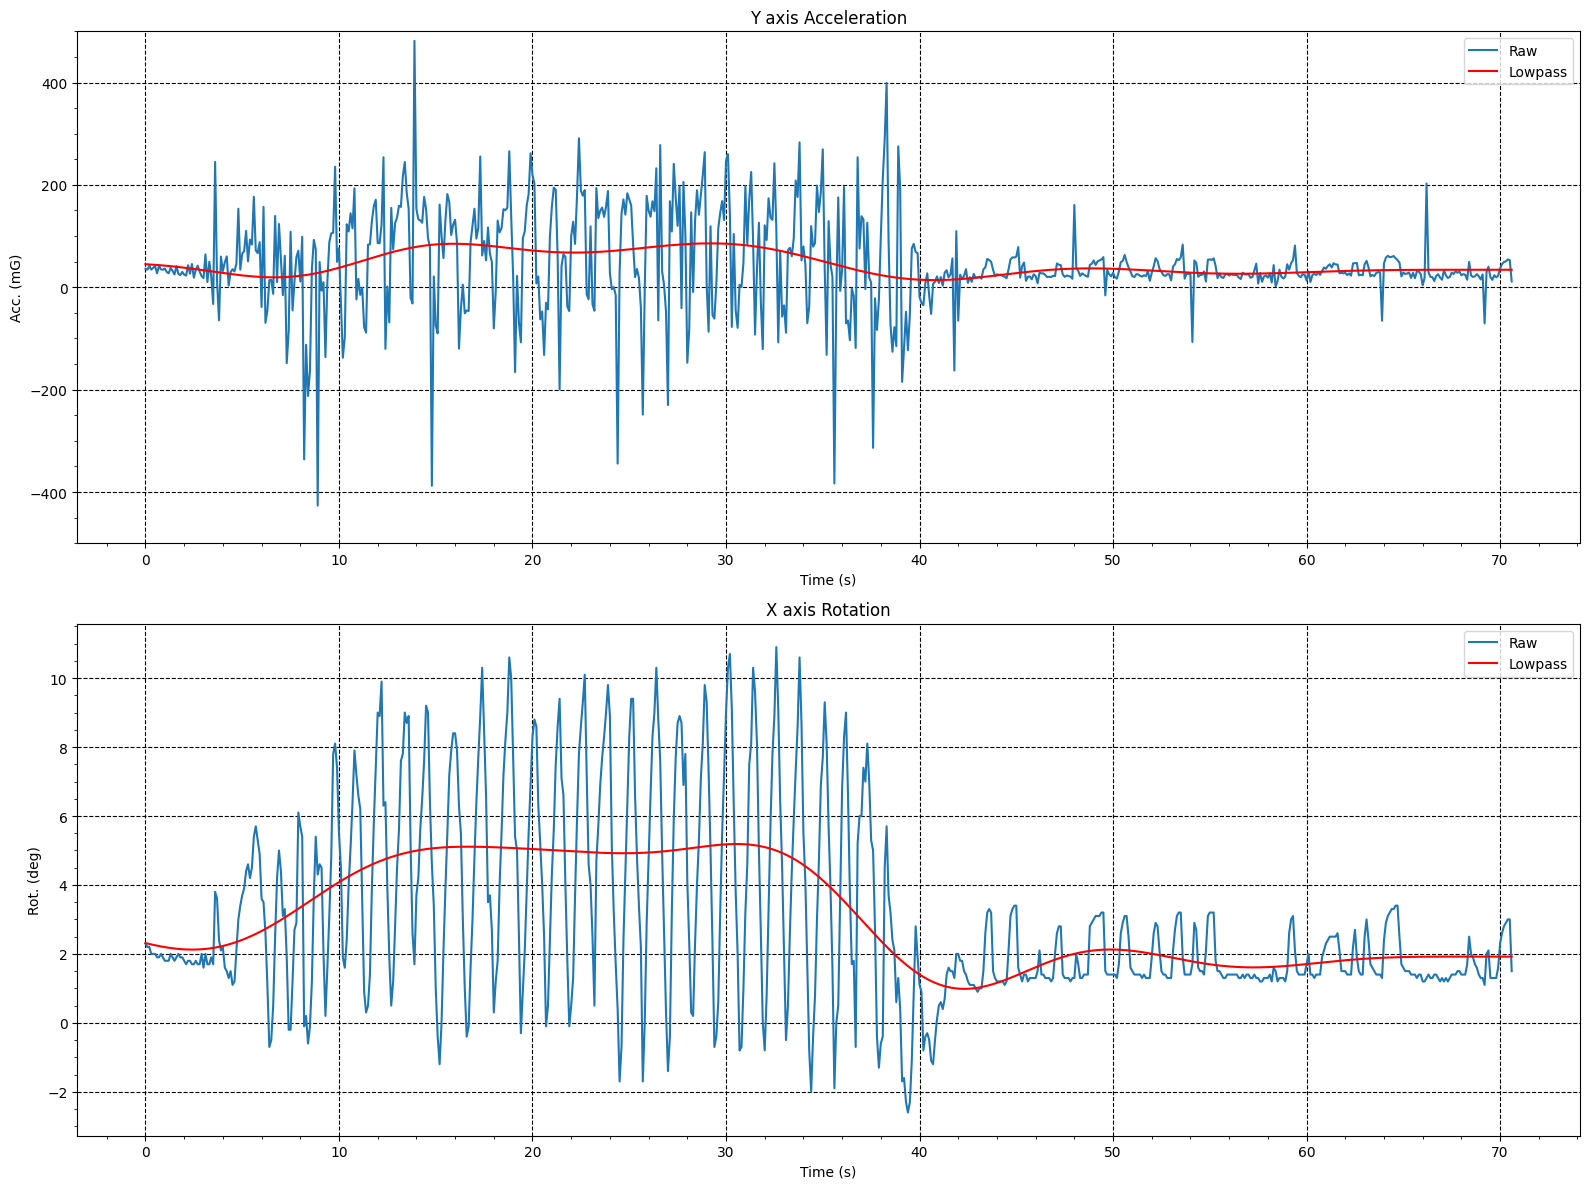

In [4]:
samplerate = 10 # サンプリング周波数は10Hz
fp = 0.08 # 通過域端周波数[Hz]
fs = 0.2 # 阻止域端周波数[Hz]
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

x = np.arange(0, m5stack.shape[0]) / samplerate
AccY = m5stack[:,5]
RotX = m5stack[:,7]

# ローパスをする関数を実行
AccY_lofilt = lowpass(AccY, samplerate, fp, fs, gpass, gstop)
RotX_lofilt = lowpass(RotX, samplerate, fp, fs, gpass, gstop)

# グラフ描画
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(x,AccY)
ax1.plot(x,AccY_lofilt,'r')
ax1.legend(['Raw','Lowpass'])
ax1.set_title('Y axis Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Acc. (mG)')
ax1.set_ylim(-500,500)
ax1.minorticks_on()
ax1.grid(color="black", linestyle="--")

ax2.plot(x,RotX)
ax2.plot(x,RotX_lofilt,'r')
ax2.legend(['Raw','Lowpass'])
ax2.set_title('X axis Rotation')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Rot. (deg)')
ax2.minorticks_on()
ax2.grid(color="black", linestyle="--")

fig.tight_layout()              #レイアウトの設定
#plt.savefig('up.png') # PNGファイルとしてグラフを保存
plt.show()

上が前後加速度，下が前後の傾き